In [1]:
import matplotlib.pyplot as plt
from glob import glob

import cv2
import os
import numpy as np
import time
import base64
import codecs, json
import pickle

from PIL import Image


# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
#from keras_retinanet.utils.gpu import setup_gpu
from keras.models import Model



Using TensorFlow backend.


# test_input에 대해서 object detection 수행

In [2]:

# object detection
model_path = os.path.join('./keras-retinanet', 'snapshots', 'resnet50_coco_best_v2.1.0.h5')

dataset_path = "./original_test/"
output_path = "./detected_data/detected_from_test/"


retina_model = models.load_model(model_path, backbone_name='resnet50')
os.chdir(dataset_path)
dataset_list = os.listdir(os.getcwd())
os.chdir('../')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/home/plass-heesu/anaconda3/envs/tf1.15/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
from object_detection2 import object_detection
objectList = object_detection(retina_model, dataset_list, dataset_path, output_path)


handling person000518.png
image shape: (392, 640, 3)
resized image size: (800, 1306, 3) scale: 2.0408163265306123

(1, 300, 4) (1, 300) (1, 300)
processing time:  3.235623359680176
detection 완료!


# detected object를 선택


In [4]:
len(objectList)

6

In [5]:
selectedObject = objectList[1]["objectPath"]

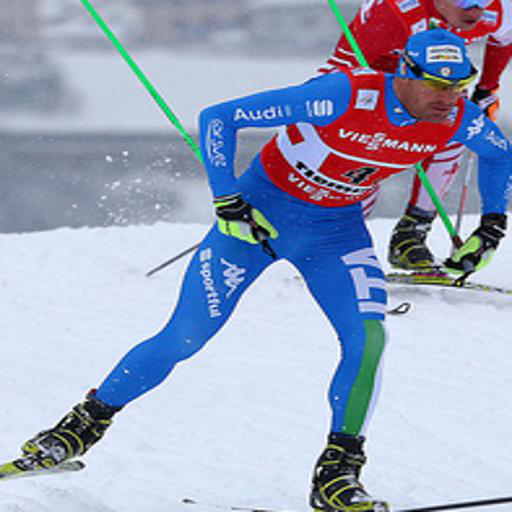

In [6]:
image_pil = Image.open(selectedObject)
image_pil

1. readTest 다시 짜기 > selectedObject 하나만 읽어야함
2. read_imgs_test를 다시짜야함
3. apply_transformer도 selectedObject 하나만 변환하도록

In [7]:
from ImageRetrievalClass import ImageRetrievalClass
retrieval = ImageRetrievalClass("ResNet50v2", True, False)
retrieval.readTestSet(selectedObject)

Reading train images


In [12]:
retrieval.buildModel()

Loading ResNet50v2 pre-trained model...
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
_________________________________________________

TypeError: __int__ returned non-int (type NoneType)

In [10]:
retrieval.shape_img_resize


AttributeError: 'ImageRetrievalClass' object has no attribute 'shape_img_resize'